In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import random
import itertools
from scipy.stats import pearsonr
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import multiclass
from sklearn import svm
import matplotlib.pyplot as plt

In [2]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [3]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [4]:
cf = RandomForestClassifier(n_estimators = 50)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()

In [5]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,0.003307,0.002409,...,1.280704,1.386294,1.396967,0.000703,0.065298,0.006188,0.009186,3.487845,14.708341,0.012476
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.005253,0.008123,...,0.959580,0.575852,0.742688,0.005957,0.897089,0.034245,0.087334,6.468010,51.769176,0.011136
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.005203,0.009098,...,1.217019,0.722551,0.846374,0.006222,0.897081,0.042083,0.088483,6.029726,46.903740,0.011594
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,0.004530,0.006995,...,1.207064,0.759448,0.988522,0.002867,0.262082,0.024327,0.038040,2.970488,10.522799,0.014210
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.006927,0.013675,...,1.319454,0.953987,1.503321,0.007170,0.752276,0.065797,0.091757,3.083533,14.513282,0.016023


In [22]:
def TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    # ClinicDataFeatures = reduced features list
    # ClinicDataFeatures2 = expanded features list
    # ClinicDataFeatures3 = only Northwestern site subjects; expanded features list
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    if type(DataFeatures[label_type].values[-1]) != str:
        DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
        DataFeatures = DataFeatures[DataFeatures[label_type].apply(lambda x: groupDict[x]) != 'Excld']
        
    features_list = list(DataFeatures.columns[8:])
    
    if bestFeatIdx:
        best_features_list = []
        for idx in bestFeatIdx:
            best_features_list = best_features_list + [features_list[idx]]
        features_list = best_features_list
    
    print('Label = ' + label_type)
    print('--------------------------------------------------')
    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    if newLab:
        print('--------------------------------------------------')
        print('Label Groups:')
        for label in newLab:
            print('    ' + label)

#     # randomly deselect scores of 0 to prevent overfitting
#     if type(DataFeatures[label_type].values[-1]) != str:
#         sympidx = DataFeatures[label_type] != 0
#         zeroidx = DataFeatures[label_type] == 0
#         ZeroDataFeatures = DataFeatures[zeroidx]
#         ZeroDataFeatures = ZeroDataFeatures.sample(1000)
#         DataFeatures = pd.concat([DataFeatures[sympidx], ZeroDataFeatures])
#         print(len(DataFeatures))
    
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    
    le.fit(Y)
    Y = le.transform(Y)
    
#     # test model with training features for overfitting
#     CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
#     FeatInp = np.zeros(shape = (1, 1))
#     TrainFeat = X
#     TrainLab = Y
#     TestFeat = X
#     TestLab = Y
#     cf.fit(TrainFeat, TrainLab)
#     PredLab = cf.predict(TestFeat)
#     TestLab = le.inverse_transform(TestLab)
#     PredLab = le.inverse_transform(PredLab)
#     CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
#     for i in range(len(CM)):
#         CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100

    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    
    plt.figure(figsize = (12, 10))
    
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]

        TestFeat = X[testInd]
        TestLab = Y[testInd]
        
        cf.fit(TrainFeat, TrainLab)
        
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break

            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
        
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))

        
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        
        PredLab = cf.predict(TestFeat)

        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)

        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
        
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
        
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100
            
    if len(groups) == 2:
        plt.show()
        
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    print(len(DataFeatures))
    print(len(TestPred))
    
    return cf, FeatImp, TestPred, DataFeatures

Label = Tremor
--------------------------------------------------
Tasks Considered:
    Walking
--------------------------------------------------
Label Groups:
    NoSymp
    Symp


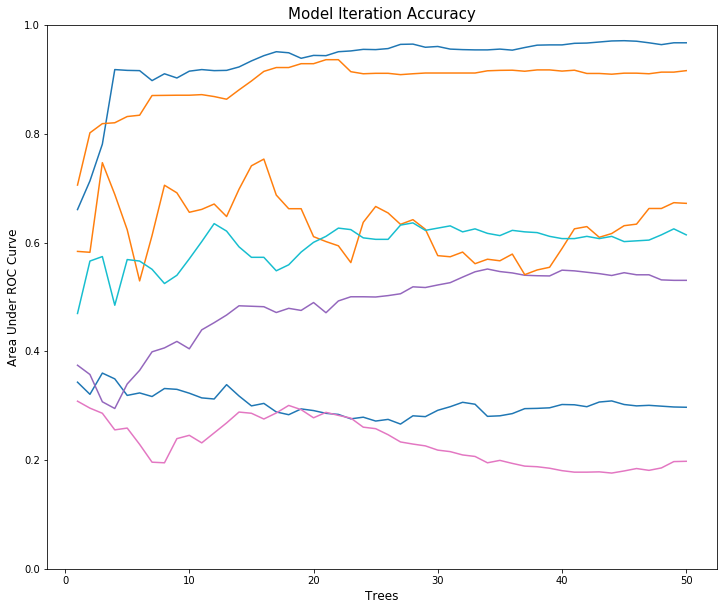

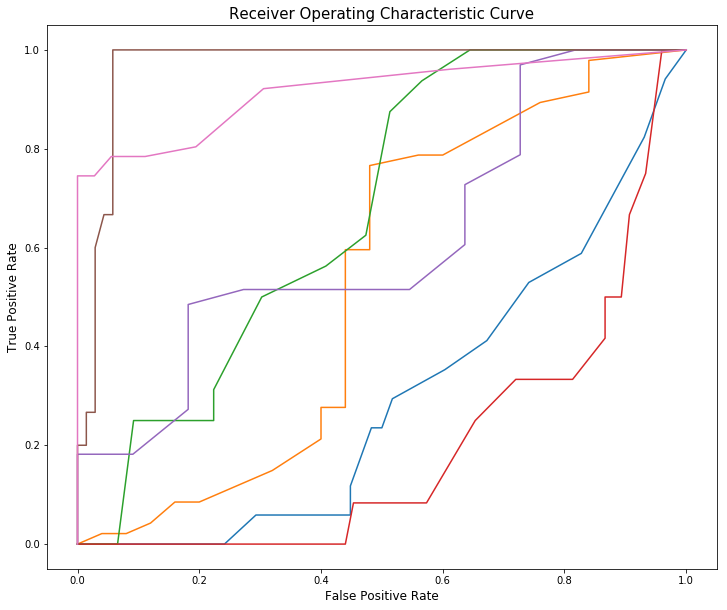

1749
1749


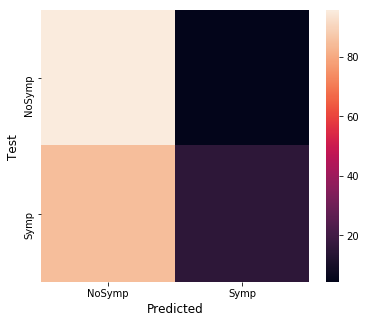

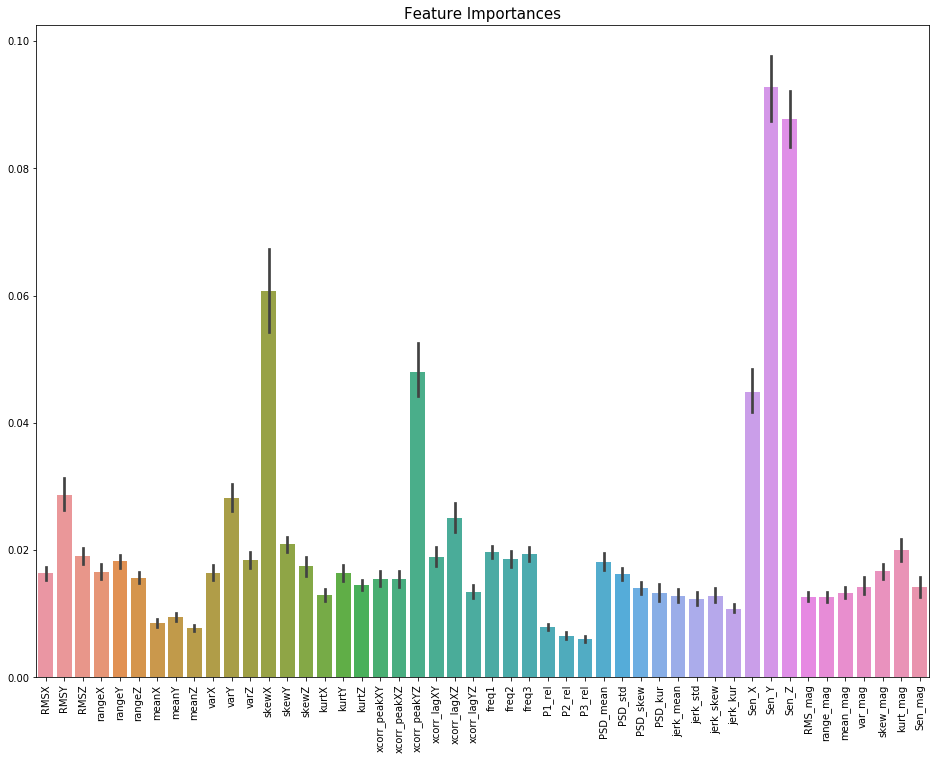

In [60]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
# tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

tasks = ['Wlkg']

### NEWLAB, GROUPS
# newLab, groups = ['Excld', 'Ram', 'Ftn', 'Rest', 'Wlkg', 'FinMot'], [['SitStand'], ['RamL', 'RamR'], ['FtnL', 'FtnR'], ['Sitng', 'Stndg', 'Drwg'], ['Wlkg', 'WlkgCnt'], ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']]
newLab, groups = ['NoSymp', 'Symp'], [[float(0)], [float(1), float(2), float(3), float(4)]]
# newLab, groups = [], []

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

bestFeatIdx = []

## RERUN MODEL WITH ONLY N MOST IMPORTANT FEATURES
# model, FeatImp = TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx)
# AvgFeatImp = np.mean(FeatImp, axis = 0)
# bestFeatIdx = list(AvgFeatImp.argsort()[-10:][::-1])

model, FeatImp, TestPred, DataFeatures = TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx)

In [61]:
TPind = (TestPred.TestLabs == 'Symp') & (TestPred.PredLabs == 'Symp')
TPDataFeatures = DataFeatures.reset_index()[TPind]

TPClipFiles = []
for clip in TPDataFeatures.iterrows():
    File = str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip'])
    TPClipFiles = TPClipFiles + [File]
TPClipFiles

['1009_1_Wlkg_10',
 '1009_4_Wlkg_8',
 '1048_3_Wlkg_0',
 '1048_3_Wlkg_3',
 '1048_3_Wlkg_4',
 '1048_3_Wlkg_5',
 '1048_3_Wlkg_6',
 '1048_3_Wlkg_7',
 '1048_3_Wlkg_8',
 '1048_3_Wlkg_9',
 '1048_3_Wlkg_10',
 '1048_4_Wlkg_3',
 '1048_4_Wlkg_4',
 '1048_4_Wlkg_5',
 '1048_4_Wlkg_6',
 '1048_4_Wlkg_7',
 '1048_4_Wlkg_8',
 '1048_4_Wlkg_10',
 '1048_4_Wlkg_11',
 '1049_0_Wlkg_0',
 '1049_0_Wlkg_2',
 '1049_0_Wlkg_5',
 '1049_0_Wlkg_6',
 '1049_0_Wlkg_7',
 '1049_0_Wlkg_10',
 '1049_0_Wlkg_11',
 '1049_0_Wlkg_13',
 '1049_0_Wlkg_14',
 '1050_0_Wlkg_0',
 '1050_0_Wlkg_1',
 '1050_0_Wlkg_2',
 '1050_0_Wlkg_3',
 '1050_0_Wlkg_4',
 '1050_0_Wlkg_5',
 '1050_0_Wlkg_7',
 '1050_0_Wlkg_9',
 '1050_1_Wlkg_0',
 '1050_1_Wlkg_1',
 '1050_1_Wlkg_2',
 '1050_1_Wlkg_10',
 '1050_2_Wlkg_1',
 '1050_2_Wlkg_2',
 '1050_2_Wlkg_3',
 '1050_2_Wlkg_11']

In [62]:
FNind = (TestPred.TestLabs == 'Symp') & (TestPred.PredLabs == 'NoSymp')
FNDataFeatures = DataFeatures.reset_index()[FNind]

FNClipFiles = []
for clip in FNDataFeatures.iterrows():
    File = str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip'])
    FNClipFiles = FNClipFiles + [File]
FNClipFiles

['1003_5_Wlkg_0',
 '1003_5_Wlkg_1',
 '1003_5_Wlkg_2',
 '1003_5_Wlkg_3',
 '1003_5_Wlkg_4',
 '1003_5_Wlkg_5',
 '1003_5_Wlkg_6',
 '1003_5_Wlkg_7',
 '1003_5_Wlkg_8',
 '1003_5_Wlkg_9',
 '1003_5_Wlkg_10',
 '1003_5_Wlkg_11',
 '1003_5_Wlkg_12',
 '1003_5_Wlkg_13',
 '1003_5_Wlkg_14',
 '1003_5_Wlkg_15',
 '1003_5_Wlkg_16',
 '1009_1_Wlkg_0',
 '1009_1_Wlkg_1',
 '1009_1_Wlkg_2',
 '1009_1_Wlkg_3',
 '1009_1_Wlkg_4',
 '1009_1_Wlkg_5',
 '1009_1_Wlkg_6',
 '1009_1_Wlkg_7',
 '1009_1_Wlkg_8',
 '1009_1_Wlkg_9',
 '1009_1_Wlkg_11',
 '1009_2_Wlkg_0',
 '1009_2_Wlkg_1',
 '1009_2_Wlkg_2',
 '1009_2_Wlkg_3',
 '1009_2_Wlkg_4',
 '1009_2_Wlkg_5',
 '1009_2_Wlkg_6',
 '1009_2_Wlkg_7',
 '1009_2_Wlkg_8',
 '1009_2_Wlkg_9',
 '1009_3_Wlkg_0',
 '1009_3_Wlkg_1',
 '1009_3_Wlkg_2',
 '1009_3_Wlkg_3',
 '1009_3_Wlkg_4',
 '1009_3_Wlkg_5',
 '1009_3_Wlkg_6',
 '1009_3_Wlkg_7',
 '1009_3_Wlkg_8',
 '1009_3_Wlkg_9',
 '1009_3_Wlkg_10',
 '1009_3_Wlkg_11',
 '1009_3_Wlkg_12',
 '1009_3_Wlkg_13',
 '1009_3_Wlkg_14',
 '1009_4_Wlkg_0',
 '1009_4_Wlkg_1

1009_1_FtnL_3
['1005_3_FtnL_8', '1005_3_FtnL_9', '1009_1_FtnL_0', '1009_1_FtnL_1', '1009_1_FtnL_2', '1009_1_FtnL_3', '1009_1_FtnL_4', '1009_1_FtnL_5', '1009_1_FtnL_6', '1009_1_FtnL_7']


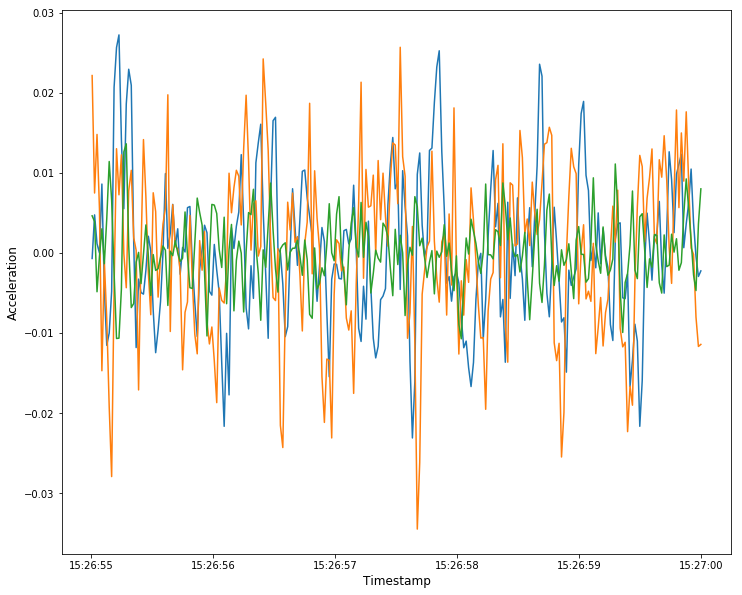

In [25]:
TP = False
FN = True
clip = 66

if TP:
    Clip = (pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', TPClipFiles[clip] + '.csv'), 
                        parse_dates = ['Timestamp']) [['Timestamp', 'X', 'Y', 'Z']])
elif FN:
    Clip = (pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', FNClipFiles[clip] + '.csv'), 
                        parse_dates = ['Timestamp']) [['Timestamp', 'X', 'Y', 'Z']])
plt.figure(figsize = (12, 10))
plt.plot(Clip.Timestamp, Clip.X, Clip.Timestamp, Clip.Y, Clip.Timestamp, Clip.Z)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Acceleration', fontsize = 12)
if TP:
    print(TPClipFiles[clip])
    print(TPClipFiles[clip - 5:clip + 5])
elif FN:
    print(FNClipFiles[clip])
    print(FNClipFiles[clip - 5:clip + 5])

1009_1_FtnL


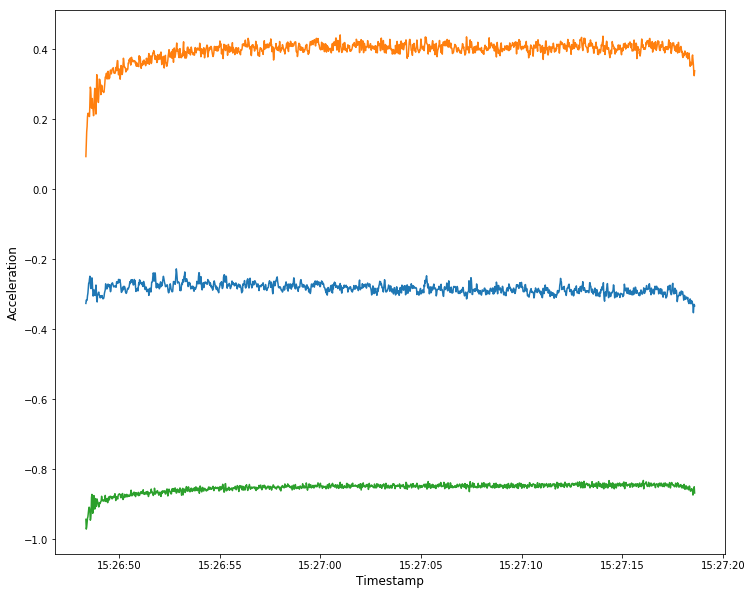

In [26]:
task = '1009_1_FtnL'
Task = (pd.read_csv(os.path.join(clinicpath, 'TaskAcc', task + '.csv'), parse_dates = ['timestamp'])
        [['timestamp', 'x', 'y', 'z']])
plt.figure(figsize = (12, 10))
plt.plot(Task.timestamp, Task.x, Task.timestamp, Task.y, Task.timestamp, Task.z)
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('Acceleration', fontsize = 12)
print(task)

In [63]:
FNDataFeatures

,index,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
58,889,1003.0,5,Wlkg,0,1.0,0.0,0.0,0.0,0.006422,...,0.790122,1.144689,0.955131,0.002883,0.304470,0.021252,0.035388,4.378548,25.230850,0.013367
59,890,1003.0,5,Wlkg,1,1.0,0.0,0.0,0.0,0.011395,...,0.677242,0.732762,0.611298,0.015542,1.540851,0.111869,0.217699,4.207750,19.814781,0.011911
60,891,1003.0,5,Wlkg,2,1.0,0.0,0.0,0.0,0.011388,...,1.083308,0.714626,0.847895,0.015664,1.540007,0.120378,0.214749,4.298674,20.490080,0.009879
61,892,1003.0,5,Wlkg,3,1.0,0.0,0.0,0.0,0.006745,...,1.163151,0.706297,1.051903,0.003829,0.259463,0.046720,0.037937,2.356109,8.411515,0.020735
62,893,1003.0,5,Wlkg,4,1.0,0.0,0.0,0.0,0.008499,...,0.980829,0.661178,1.034996,0.004177,0.253134,0.047608,0.040089,2.371553,7.756062,0.022725
63,894,1003.0,5,Wlkg,5,1.0,0.0,0.0,0.0,0.009627,...,1.102557,0.813531,1.030092,0.004224,0.271050,0.046574,0.042541,2.351217,7.656274,0.020857
64,895,1003.0,5,Wlkg,6,1.0,0.0,0.0,0.0,0.008268,...,1.250089,0.755646,0.906518,0.003820,0.271050,0.044734,0.040213,2.183174,6.685055,0.018776
65,896,1003.0,5,Wlkg,7,1.0,0.0,0.0,0.0,0.008082,...,1.054734,0.727289,1.028102,0.004022,0.265664,0.048000,0.041326,2.211947,6.240251,0.018434
66,897,1003.0,5,Wlkg,8,1.0,0.0,0.0,0.0,0.007793,...,1.110218,0.774856,1.086118,0.003686,0.265664,0.044182,0.037654,2.107810,6.875095,0.020382
67,898,1003.0,5,Wlkg,9,1.0,0.0,0.0,0.0,0.007347,...,1.224197,0.860812,1.076730,0.003881,0.445391,0.038170,0.047731,4.415687,28.973726,0.013903
